# [Darshan-LDMS Integrator - AWS](https://ovis-hpc.readthedocs.io/en/latest/ldms/ldms-streams.html#darshans)

Execution of IOR in AWS instance (1 rank) collecting LDMS-Darshan information.

AWS m1.small general purpose instance with 1 vCPUs, 1.7 GiB memor, starting at $0.044/hr

*$ /home/ubuntu/ior/src/ior -i 2 -b 16m -t 4m -s 32 -F -C -e -k*

*$ /home/ubuntu/ior/src/ior -i 10 -b 16m -t 4m -s 64 -F -C -e -k*

### Code to generate the summary

In [3]:
import os, csv, time, glob, argparse, psutil, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import rpy2.robjects as ro
import seaborn as sns
from datetime import datetime
from math import sqrt, ceil
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore') 

class Job:

    def __init__(self, job, ranks, nodes, users, filename, exe):
        
        self.job = job
        self.ranks = ranks
        self.nodes = nodes
        self.users = users
        self.filename = filename
        self.exe = exe

def app_phase(df, output_file, self):
    write_to_file("---------------------------------------")
    write_to_file("EXECUTION SUMMARY PER APPLICATION PHASE:")
    write_to_file("---------------------------------------")

# Calculate and write general statistics in a file
def get_statistics(df, output_file, self):

    with open(output_file, 'w') as f:

        def write_to_file(*args):
            print(" ".join(map(str, args)), file=f, flush=True)

        write_to_file("---------------------------------------")
        write_to_file("JOB CHARACTERISTICS:")
        write_to_file("---------------------------------------")
        write_to_file("Job ID:", self.job)
        write_to_file(len(self.ranks), "Rank (s):", sorted(self.ranks))
        write_to_file(len(self.nodes), "Node (s):", sorted(self.nodes))
        write_to_file("User ID:", self.users)
        write_to_file("Directory:", self.exe)
        write_to_file("Modules collected:", df['module'].unique())
        write_to_file("Module events (MOD):", list(df.type).count('MOD'))
        write_to_file("Meta events (MET):", list(df.type).count('MET'))

        df_read = df[df['op'] == "read"]
        df_write = df[df['op'] == "write"]
        df_open = df[df['op'] == "open"]
        df_close = df[df['op'] == "close"]

        write_to_file("---------------------------------------")
        write_to_file("I/O OPERATIONS:")
        write_to_file("---------------------------------------")

        exec_time = round(df['end'].max() - df['start'].min(), 5)
        write_to_file("Total I/O makespan:", exec_time, "seconds")
        write_to_file("Cumulative I/O duration:", round(df['dur'].sum(), 5), "seconds")
        write_to_file("Bandwidth (MiB/second):", round((df['len'].sum() / exec_time) / (1024 ** 2), 5))
        write_to_file("IOPS:", round(len(df)/exec_time, 5), "\n")

        current_op = None
        phase_start = None
        total_durations = {'read': 0, 'write': 0, 'open': 0, 'close': 0}

        def update_total_duration(op, phase_start, phase_end, length):
            if current_op is not None and current_op == op:
                total_durations[op] += (phase_end - phase_start)

        for index, row in df.iterrows():
            if current_op is None or current_op != row['op']:
                update_total_duration(current_op, phase_start, row['end'], row['len'])
                current_op = row['op']
                phase_start = row['start']

        # Get the last phase
        update_total_duration(current_op, phase_start, row['end'], row['len'])

        pivot_df = df.pivot_table(index=None, columns='op', values='len', aggfunc='sum')
        for op, duration in total_durations.items():
            write_to_file(f'Duration {op}s: {round(duration, 4)} seconds')

        write_to_file("\n# of reads: ", len(df_read))
        write_to_file("Cumulative I/O duration:",round(df_read['dur'].sum(),2))
        write_to_file("Total bytes:",round(df_read['len'].sum() / (1024 ** 2)),  "MiB")
        write_to_file("Min data size per rank:", round(df_read.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Max data size per rank:", round(df_read.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        # write_to_file("Bandwidth (MiB/second):", round((df_read['len'].sum() / total_durations['read']) / (1024 ** 2), 2))
        # write_to_file("IOPS:", round(len(df_read)/total_durations['read'], 2))

        write_to_file("\n# of writes: ", len(df_write))
        write_to_file("Cumulative I/O duration:",round(df_write['dur'].sum(), 2))
        write_to_file("Total bytes:",round(df_write['len'].sum() / (1024 ** 2)),  "MiB")
        write_to_file("Min data size per rank:", round(df_write.groupby('rank')['len'].agg('sum').min() / (1024 ** 2)), "MiB")
        write_to_file("Max data size per rank:", round(df_write.groupby('rank')['len'].agg('sum').max() / (1024 ** 2)), "MiB")
        # write_to_file("Bandwidth (MiB/second):", round((df_write['len'].sum() / total_durations['write']) / (1024 ** 2),2))
        # write_to_file("Mean IOPS:", round((df_write.groupby('rank').size() / df_write.groupby('rank')['dur'].sum()).mean(), 2))
        # write_to_file("IOPS:", round(len(df_write)/total_durations['write'], 2))

        write_to_file("\n# of opens: ", len(df_open))
        write_to_file("\n# of closes: ", len(df_close))

        # IMBALANCE METRICS:
        write_to_file("---------------------------------------")
        write_to_file("I/O PROGRESS RATE:")
        write_to_file("---------------------------------------")
        # Get difference between execution time and time processing I/O per rank
        
        df_idle = df.groupby('rank')['dur'].sum().reset_index()
        df_idle.columns = ['Rank ID', 'Rank I/O Time (sec)']
        df_idle['Total Bytes'] = df.groupby('rank')['len'].agg('sum')
        df_idle['Rank I/O Time (sec)'] = round(df_idle['Rank I/O Time (sec)'], 2)
        # df_idle['Total I/O Time - Rank I/O Time'] = round(exec_time - df_idle['Rank I/O Time'], 2)
        df_idle = df_idle.sort_values(by='Rank I/O Time (sec)', ascending=False)
        
        num_ranks = len(self.ranks)
        average = df['dur'].sum() / num_ranks
        write_to_file("- Average:", round(average, 2), "seconds")
        std = np.std(df_idle['Rank I/O Time (sec)'])
        write_to_file("- Standard Deviation", round(std, 2), "seconds")
        it = df_idle['Rank I/O Time (sec)'].max() - average
        write_to_file("- Imbalance Time:", round(it, 2), "seconds")
        pi = ((df_idle['Rank I/O Time (sec)'].max() / average) - 1) * 100
        write_to_file("- Percent Imbalance:", round(pi, 2), "%")
        ti = exec_time - df.groupby('rank')['dur'].sum().max()
        write_to_file("- Time Interval:", round(ti, 2), "seconds")
        # ip = (it / df_idle['Rank I/O Time (sec)'].max()) * (num_ranks / (num_ranks - 1))
        # write_to_file("- Imbalance Percentage:", round(ip, 2), "%")

        write_to_file("---------------------------------------")
        write_to_file("SUMMARY PER RANK: \n(ordered by higher I/O time - all ops)")
        write_to_file("---------------------------------------")
        df.loc[:, 'start'] = pd.to_datetime(df['start'], unit='s').dt.round('S')
        df.loc[:, 'end'] = pd.to_datetime(df['end'], unit='s').dt.round('S')
        # write_to_file(df_idle)
        write_to_file(df_idle.to_string(index=False))

### Code for generating visualizations

In [35]:
# Show total I/O duration per rank and operation
def plot_time_per_operation(df, filepath, job_id):

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    
    fig, axes = plt.subplots(1, 4, figsize=(8, 3.5)) 

    for ax, operation in zip(axes, ['write','read', 'open', 'close']):
        df_subset = df[df['op'] == operation].groupby('rank')['dur'].sum().reset_index()
        df_subset.plot(kind='barh', y='dur', x='rank', color=colors[operation], ax=ax, width=0.8)
        ax.set_xlabel('Total I/O duration (sec)')
        ax.set_ylabel('Rank')
        ax.set_yticks(range(0, df_subset['rank'].max(), ceil(df_subset['rank'].max()/10)))
        ax.set_title(operation.capitalize()) 
        ax.get_legend().remove()
        ax.set_xlim(0, df_subset['dur'].max())

    plt.tight_layout()
    plt.show()
    plt.close()
    plt.clf()
    return
 
# Show bandwidth per rank and operation 
def plot_bandwidth_per_rank(df, filepath, job_id):

    df = df[df['op'].isin(['write', 'read'])]
    df['bw'] = np.where(df['dur'] != 0, df['len'] / (df['dur'] * 2**20), 0)
    colors = {'write': 'blue', 'read': 'orange'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
     
    for ax, operation in zip(axes, ['write','read']):
        df_subset = df[df['op'] == operation].groupby('rank')['bw'].mean().reset_index()
        df_subset.plot(kind='barh', y='bw', x='rank', color=colors[operation], ax=ax, width=0.8)

        ax.set_xlabel('Total Bandwidth (MiB/second)')
        ax.set_ylabel('Rank')
        ax.set_yticks(range(0, df_subset['rank'].max(), ceil(df_subset['rank'].max()/10)))
        ax.set_title(operation.capitalize()) 
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

    return

# Plot each I/O event per rank during time
def plot_temporal(df, filepath, job_id):

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') 
    df['dur'] = pd.to_timedelta(df['dur'], unit='s')
    df['start'] = df['timestamp'] - df['dur']
    df['start'] = pd.to_datetime(df['start'], unit='s').dt.tz_localize('UTC').dt.tz_convert('America/Denver')
    df['start'] = df['start'].dt.tz_localize(None)

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    df['color'] = df['op'].map(colors)

    fig, ax = plt.subplots(figsize=(18, 3.5))

    ax.barh(y=df['rank'], width=df['dur'], left=df['start'], color=df['color'])
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Rank')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'[:-3]))
    ax.set_yticks(range(0, df['rank'].max(), ceil(df['rank'].max()/10)))
    legend_labels = [plt.Line2D([0], [0], color=color, linewidth=3, linestyle='-') for op, color in colors.items()]
    ax.legend(legend_labels, colors.keys(), loc='upper right')
    first_date = df['start'].iloc[0]
    ax.set_title(first_date.strftime("Date: " + '%Y-%m-%d'))
    ax.set_ylim(df['rank'].min()-0.5, df['rank'].max()+0.5)
    min_time = df['start'].min()
    max_time = df['start'].max()

    plt.show()
    plt.clf()
    plt.close()

    return

def plot_temporal_points(df):

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') 
    df['dur'] = pd.to_timedelta(df['dur'], unit='s')
    df['start'] = df['timestamp'] - df['dur']
    df['start'] = pd.to_datetime(df['start'], unit='s').dt.tz_localize('UTC').dt.tz_convert('America/Denver')
    df['start'] = df['start'].dt.tz_localize(None)

    colors = {'write': 'blue', 'open': 'green', 'close': 'red', 'read': 'orange'} 
    df['color'] = df['op'].map(colors)
    fig, ax = plt.subplots(figsize=(15, 1))

    # Plot bars for reads and writes
    for op in ['read', 'write']:
        op_data = df[df['op'] == op]
        ax.barh(y=op_data['rank'], width=op_data['dur'], left=op_data['start'], color=op_data['color'])

    # Plot points for opens and closes 
    op_data = df[df['op'] == 'open']
    ax.scatter(op_data['start'], op_data['rank'], color=op_data['color'], label=op, zorder=5, marker="2")
    op_data = df[df['op'] == 'close']
    ax.scatter(op_data['start'], op_data['rank'], color=op_data['color'], label=op, zorder=5, marker="1") 
 
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Rank')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'[:-3]))
    # ax.set_yticks(range(0, df['rank'].max() + 1, ceil(df['rank'].max()/10)))

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=op) for op, color in colors.items() if op in ['read', 'write']]
    legend_elements += [plt.Line2D([0], [0], marker='2', color=colors['open'], markersize=10, markerfacecolor=colors['open'], label='open')]
    legend_elements += [plt.Line2D([0], [0], marker='1', color=colors['close'], markersize=10, markerfacecolor=colors['close'], label='close')]
    
    # ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(df['rank'].min()-0.5, df['rank'].max()+0.5)
    first_date = df['start'].iloc[0]
    ax.set_title(first_date.strftime("Date: %Y-%m-%d"))

    plt.show()
    plt.clf()
    plt.close()

    return

# Plot the accumulated time without processing I/O operations 
def io_straggler(df):

    df_read_write = df[df['op'].isin(['read', 'write'])]
    df = df[df['op'].isin(['open', 'close'])]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['start'] = df['timestamp'] - pd.to_timedelta(df['dur'], unit='s')

    intervals = []
    current_id = 1
    for rank in df['rank'].unique():
        current_open = None
        current_id = 1
        for index, row in df[df['rank'] == rank].iterrows():
            if row['op'] == 'open':
                if current_open is None:
                    current_open = row['start']
                else:
                    intervals.append((row['rank'], current_id, (row['start'] - current_open)))
                    current_id += 1
                    current_open = row['start']
            else:
                if current_open is not None:
                    intervals.append((row['rank'], current_id, row['start'] - current_open))
                    current_open = None
                    current_id = 1

    computations = df_read_write.groupby('rank')['dur'].sum().reset_index()
    result = pd.DataFrame(intervals, columns=['rank', 'id', 'interval'])
    result['interval'] = result['interval'].dt.total_seconds()

    df_plot = pd.merge(result.groupby('rank')['interval'].sum().reset_index(), computations, on='rank')
    df_plot['communication'] = df_plot['interval'] - df_plot['dur']
    
    # Get top-3
    top_ranks = df_plot.sort_values('communication', ascending=False)

    # Plot results
    fig, ax = plt.subplots(figsize=(6, 5))
    # ax.barh(df_plot['rank'], df_plot['communication'])
    for index, row in df_plot.iterrows():
        color = 'red' if row['rank'] in top_ranks['rank'].head(3).values else 'blue'
        ax.barh(row['rank'], row['communication'], color=color)
        
    ax.set_yticks(range(0, df['rank'].max() + 1, ceil(df['rank'].max()/10)))
    ax.set_xlabel('Accumulated time between operations (sec)')
    ax.set_ylabel('Rank')
    ax.set_ylim(df['rank'].min()-0.5, df['rank'].max()+0.5)

    plt.show()
    plt.clf()
    plt.close()

    return

## Comparing outputs, same experiment, multiple repetitions

```
$ /home/ubuntu/ior/src/ior -i 2 -b 16m -t 4m -s 32 -F -C -e -k 
LDMS library: Error 111 setting up connection to LDMS streams daemon.
IOR-4.1.0+dev: MPI Coordinated Test of Parallel I/O
Began               : Tue Jun 18 20:00:08 2024
Command line        : /home/ubuntu/ior/src/ior -i 2 -b 16m -t 4m -s 32 -F -C -e -k
Machine             : Linux ip-172-31-89-93
TestID              : 0
StartTime           : Tue Jun 18 20:00:08 2024
Path                : testFile.00000000
FS                  : 6.7 GiB   Used FS: 74.1%   Inodes: 0.9 Mi   Used Inodes: 13.7%

Options: 
api                 : POSIX
apiVersion          : 
test filename       : testFile
access              : file-per-process
type                : independent
segments            : 32
ordering in a file  : sequential
ordering inter file : constant task offset
task offset         : 1
nodes               : 1
tasks               : 1
clients per node    : 1
memoryBuffer        : CPU
dataAccess          : CPU
GPUDirect           : 0
repetitions         : 2
xfersize            : 4 MiB
blocksize           : 16 MiB
aggregate filesize  : 512 MiB

Results: 
WARNING: The file "testFile.00000000" exists already and will be deleted

access    bw(MiB/s)  IOPS       Latency(s)  block(KiB) xfer(KiB)  open(s)    wr/rd(s)   close(s)   total(s)   iter
------    ---------  ----       ----------  ---------- ---------  --------   --------   --------   --------   ----
write     18.71      4.68       6.84        16384      4096       0.000072   27.37      0.000015   27.37      0   
read      5378       1345.05    0.023791    16384      4096       0.000030   0.095164   0.000010   0.095206   0 
write     18.22      4.55       7.03        16384      4096       0.000067   28.11      0.000012   28.11      1   
read      5155       1289.10    0.024823    16384      4096       0.000017   0.099294   0.000010   0.099322   1   

Summary of all tests:
Operation   Max(MiB)   Min(MiB)  Mean(MiB)     StdDev   Max(OPs)   Min(OPs)  Mean(OPs)     StdDev    Mean(s) Stonewall(s) Stonewall(MiB) Test# #Tasks tPN reps fPP reord reordoff reordrand seed segcnt   blksiz    xsize aggs(MiB)   API RefNum
write          18.71      18.22      18.46       0.25       4.68       4.55       4.62       0.06   27.73949         NA            NA     0      1   1    2   1     1        1         0    0     32 16777216  4194304     512.0 POSIX      0
read         5377.81    5154.95    5266.38     111.43    1344.45    1288.74    1316.59      27.86    0.09726         NA            NA     0      1   1    2   1     1        1         0    0     32 16777216  4194304     512.0 POSIX      0
Finished            : Tue Jun 18 20:01:03 2024
```

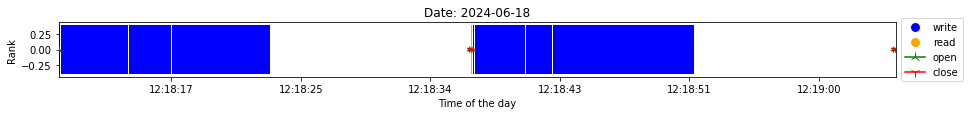

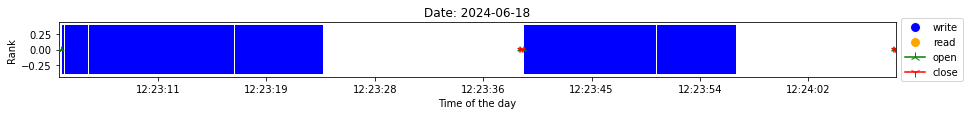

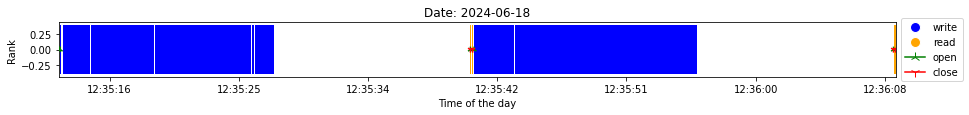

In [36]:
INPUTFILE1="./output/ior/darshanConnector-ior1.csv"
INPUTFILE2="./output/ior/darshanConnector-ior2.csv"
INPUTFILE3="./output/ior/darshanConnector-ior3.csv" 
FILEPATH="./output/ior/"
def generate_visualizations(df, filepath): 
    plot_temporal_points(df.copy()) 

df_all = pd.read_csv(INPUTFILE1, engine="pyarrow")
generate_visualizations(df_all, FILEPATH)   
df_all = pd.read_csv(INPUTFILE2, engine="pyarrow")
generate_visualizations(df_all, FILEPATH)   
df_all = pd.read_csv(INPUTFILE3, engine="pyarrow")
generate_visualizations(df_all, FILEPATH)    

```
$ sudo /home/ubuntu/ior/src/ior -i 10 -b 16m -t 4m -s 64 -F -C -e -k 

IOR-4.1.0+dev: MPI Coordinated Test of Parallel I/O
Began               : Tue Jun 18 19:45:51 2024
Command line        : /home/ubuntu/ior/src/ior -i 10 -b 16m -t 4m -s 64 -F -C -e -k
Machine             : Linux ip-172-31-89-93
TestID              : 0
StartTime           : Tue Jun 18 19:45:51 2024
Path                : testFile.00000000
FS                  : 6.7 GiB   Used FS: 59.2%   Inodes: 0.9 Mi   Used Inodes: 13.7%

Options: 
api                 : POSIX
apiVersion          : 
test filename       : testFile
access              : file-per-process
type                : independent
segments            : 64
ordering in a file  : sequential
ordering inter file : constant task offset
task offset         : 1
nodes               : 1
tasks               : 1
clients per node    : 1
memoryBuffer        : CPU
dataAccess          : CPU
GPUDirect           : 0
repetitions         : 10
xfersize            : 4 MiB
blocksize           : 16 MiB
aggregate filesize  : 1 GiB

Results: 

access    bw(MiB/s)  IOPS       Latency(s)  block(KiB) xfer(KiB)  open(s)    wr/rd(s)   close(s)   total(s)   iter
------    ---------  ----       ----------  ---------- ---------  --------   --------   --------   --------   ----
write     18.40      4.60       13.91       16384      4096       0.000036   55.64      0.000008   55.64      0   
read      25.56      6.39       10.02       16384      4096       0.000009   40.07      0.000008   40.07      0   
write     18.17      4.54       14.09       16384      4096       0.000035   56.35      0.000010   56.35      1   
read      23.40      5.85       10.94       16384      4096       0.000009   43.76      0.000008   43.76      1   
write     18.17      4.54       14.09       16384      4096       0.000034   56.37      0.000010   56.37      2   
read      23.40      5.85       10.94       16384      4096       0.000009   43.76      0.000008   43.76      2   
write     18.17      4.54       14.09       16384      4096       0.000328   56.36      0.000011   56.36      3   
read      23.39      5.85       10.94       16384      4096       0.000009   43.78      0.000009   43.78      3   
write     18.17      4.54       14.09       16384      4096       0.000037   56.36      0.000011   56.36      4   
read      25.52      6.38       10.03       16384      4096       0.000009   40.12      0.000010   40.12      4   
write     18.17      4.54       14.09       16384      4096       0.000055   56.34      0.000008   56.34      5   
read      18.71      4.68       13.68       16384      4096       0.000009   54.72      0.000009   54.72      5   
write     18.15      4.54       14.10       16384      4096       0.000035   56.41      0.000009   56.41      6   
read      18.74      4.68       13.66       16384      4096       0.000009   54.65      0.000008   54.65      6   
write     18.15      4.54       14.10       16384      4096       0.000034   56.41      0.000011   56.41      7   
read      18.11      4.53       14.13       16384      4096       0.000028   56.53      0.000008   56.53      7   
write     18.15      4.54       14.10       16384      4096       0.000039   56.42      0.000011   56.42      8   
read      18.12      4.53       14.13       16384      4096       0.000010   56.52      0.000010   56.52      8   
write     18.15      4.54       14.11       16384      4096       0.000034   56.43      0.000011   56.43      9   
read      18.11      4.53       14.13       16384      4096       0.000009   56.53      0.000009   56.53      9   

Summary of all tests:
Operation   Max(MiB)   Min(MiB)  Mean(MiB)     StdDev   Max(OPs)   Min(OPs)  Mean(OPs)     StdDev    Mean(s) Stonewall(s) Stonewall(MiB) Test# #Tasks tPN reps fPP reord reordoff reordrand seed segcnt   blksiz    xsize aggs(MiB)   API RefNum
write          18.40      18.15      18.19       0.07       4.60       4.54       4.55       0.02   56.30807         NA            NA     0      1   1   10   1     1        1         0    0     64 16777216  4194304    1024.0 POSIX      0
read           25.56      18.11      21.31       3.05       6.39       4.53       5.33       0.76   49.04452         NA            NA     0      1   1   10   1     1        1         0    0     64 16777216  4194304    1024.0 POSIX      0
Finished            : Tue Jun 18 20:18:54 2024

```

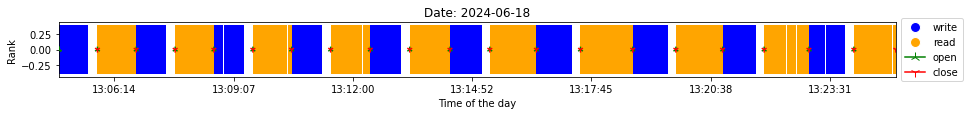

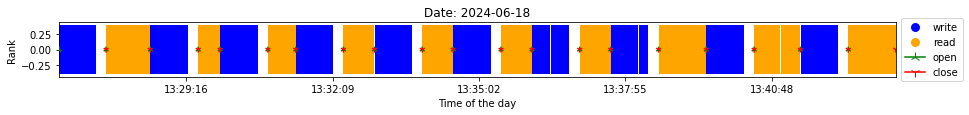

In [41]:
INPUTFILE1="./output/ior/darshanConnector-ior1-long.csv"
INPUTFILE2="./output/ior/darshanConnector-ior2-long.csv"
FILEPATH="./output/ior/"

def generate_visualizations(df, filepath): 
    plot_temporal_points(df.copy()) 

df_all = pd.read_csv(INPUTFILE1, engine="pyarrow")
generate_visualizations(df_all, FILEPATH)   
df_all = pd.read_csv(INPUTFILE2, engine="pyarrow")
generate_visualizations(df_all, FILEPATH)   

https://web.cels.anl.gov/~thakur/pio-benchmarks.html